# Music Genre Classification

### Packages

In [3]:
import os
import cv2
from tensorflow import keras
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
import sklearn
import tensorflow as tf
import pandas as pd
import itertools

from tensorflow.keras.models import (Model, Sequential)
from tensorflow.keras.layers import (Input, Add, Conv2D, MaxPooling2D, AveragePooling2D,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Activation, Dropout, 
                                     Flatten, BatchNormalization, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (GridSearchCV, train_test_split)

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm
from sklearn.preprocessing import OneHotEncoder
import joblib

#### Global Variables

In [4]:
GTZAN = {'nGenres': 10, 'genres': ['blues', 'classical', 'country', 'disco', 'hiphop', 
                                   'jazz', 'metal', 'pop', 'reggae', 'rock']}
EXTENDED_BALLROOM = {'nGenres': 9, 'genres': ['chacha', 'foxtrot', 'jive', 'quickstep', 'rumba',
                                              'samba', 'tango', 'viennesewaltz', 'waltz']}
FEATURES = ('stft', 'mfcc', 'melspectrogram', 'fouriertempogram')
RNG_STATE = 422
TEST_SIZE = 0.2
EPOCHS = 50
BATCH_SIZE = 64

# make model csv file to save stats
MODEL_COLS = ["Model Name", "Method", "Dataset", "Feature", "Split", "Test Accuracy", "Test Loss",
                                     "Train Accuracy", "Train Loss", "Best Epoch", "Validation Accuracy",
                                     "Validation Loss", "Training Accuracy", "Training Loss"]
MODEL_STATS = pd.DataFrame(columns = MODEL_COLS)
if not os.path.exists('models/models.csv'): # if not already made
    print("Created models.csv")
    MODEL_STATS.to_csv(r'models/models.csv', index = False)

### Helper Methods

In [5]:
def getFeatures(dataset, feature, split):
    # LOADING
    X = np.load(os.path.join(os.getcwd(), "datasets", dataset, "features", f"{feature}{split}-X.npy"))
    Y = np.load(os.path.join(os.getcwd(), "datasets", dataset, "features", f"{feature}{split}-Y.npy"))
    #SPLITTING
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = RNG_STATE, 
                                                        stratify = Y)
    
    return (X_train, X_test, Y_train, Y_test)

In [6]:
def plot_graph(history, title, download = True):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    if download:
        plt.savefig(f'models/graphs/{name}-Accuracy.png')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    if download:
        plt.savefig(f'models/graphs/{name}-Loss.png')
    plt.show()

In [23]:
def cnf_matrix(cm, labels, name = None):
    plt.figure(figsize=(11,11))
    
    norm_cm = cm / cm.sum(1)
    plt.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(list(range(len(labels))), labels)
    plt.yticks(list(range(len(labels))), labels)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted genre')
    plt.ylabel('True genre')
    thresh = norm_cm.max() / 2.0
    for i, j in itertools.product(range(norm_cm.shape[0]), range(norm_cm.shape[1])):
        plt.text(j, i, '{:.2g}'.format(norm_cm[i, j]),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
    
    if name:
        plt.savefig(f'{name}-ConfusionMatrix.png', dpi = 600)
    plt.show()

In [8]:
def get_res(history, epoch):
    h = history.history
    train_acc = h['categorical_accuracy'][epoch - 1]
    val_acc = h['val_categorical_accuracy'][epoch - 1]
    train_loss = h['loss'][epoch - 1]
    val_loss = h['val_loss'][epoch - 1]
    #print(train_acc, val_acc, train_loss, val_loss)
    
    return train_acc, train_loss, val_acc, val_loss

In [9]:
def get_model(mod, data, feature, split):
    models_path = os.path.join(os.getcwd(), 'models')
    for file in os.listdir(models_path):
        if file.endswith('_'.join([mod, feature.upper(), data.upper(), str(split)]) + '.h5'):
            model = keras.models.load_model(os.path.join(models_path, file))
            break
    return model

# Processing

Librosa for feature extraction of audio files\
STFT | MFCC | Melspectrogram | Fourier Tempogram

GTZAN (10 Genres)\
Extended Ballroom (9 Genres - removed 4 for having less than 100 samples)

In [ ]:
def process(dataset, feature, time_split, verbose = False, save = False):
    N_FFT = 2048
    HOP_LENGTH = 1024
    N_MELS = 64
    N_MFCC = 13
    
    processed = []
    processed_genres = []
    
    feature = feature.lower()
    aud_path = os.path.join(os.getcwd(), "datasets", dataset, "audio")
    if not os.path.exists(aud_path):
        print("Dataset not found:", aud_path)
        return
        
    features = ("stft", "melspectrogram", "mfcc", "fouriertempogram")
    TOTAL_GENRES = len(os.listdir(aud_path))

    if feature not in features:
        print(f"{feature} not available for extraction")
        return
    
    feat_path = os.path.join(os.getcwd(), "datasets", dataset, "features")
    os.path.isdir(feat_path) or os.makedirs(feat_path)
    
    currentGenre = 0
    for folder in os.listdir(aud_path):
        folder_path = os.path.join(aud_path, folder)
        for audio in os.listdir(folder_path):  
            audio_path = os.path.join(folder_path, audio)
            y, sr = librosa.load(audio_path) # can user offset and duration for 5 second intervals
            if feature == "stft":
                feat = np.abs(librosa.stft(y, hop_length = HOP_LENGTH, n_fft = N_FFT))
            elif feature == "mfcc":
                feat = librosa.feature.mfcc(y = y, sr = sr, hop_length = HOP_LENGTH, 
                                                      n_fft = N_FFT)
            elif feature == "melspectrogram":
                feat = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = N_MELS, n_fft = N_FFT,
                                                     hop_length = HOP_LENGTH)
            elif feature == "fouriertempogram":
                oenv = librosa.onset.onset_strength(y = y, sr = sr, hop_length = HOP_LENGTH)
                feat = librosa.feature.fourier_tempogram(onset_envelope = oenv, sr = sr, hop_length = HOP_LENGTH)
                #feat = librosa.feature.tempogram(onset_envelope = oenv, sr = sr, hop_length = HOP_LENGTH)
            feat = librosa.power_to_db(feat ** 2) # feat ** 2 for amplitude to db
            #if len(feat[0]) != 647:
            #    print(len(feat[0]))
            #print(feat.shape)
            #print(feat[:2, :512].shape)
            #librosa.display.specshow(feat[:, :], sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'mel')
            #print(feat.shape)
            
            # max is (x, 647) or (x, 648) -- imma treat max as 640 -- can be //10,8,5,4,2 -> 3, 3.75, 6, 7.5, 15
            out = feat[:, :640]

            # split into segments -- 3, 3.75, 6, 7.5, 15 seconds
            out_split = np.hsplit(out, time_split)
            for split in out_split:
                #print(split.shape)
                processed.append(split)
                # one hot encoding
                processed_genres.append([1 if i == currentGenre else 0 for i in range(TOTAL_GENRES)])
                #librosa.display.specshow(split[:, :], sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'mel')
            #print(len(out_split))
            #librosa.display.specshow(out[:, :], sr=sr, hop_length = HOP_LENGTH)
        currentGenre += 1
        if verbose:
            print(folder, "complete;", feature, processed[0].shape)
    
    X = np.array(processed)
    Y = np.array(processed_genres)
    
    
    if save:
        #np.save(os.path.join(feat_path, f"{feature + str(time_split)}-X.npy"), X)
        #np.save(os.path.join(feat_path, f"{feature + str(time_split)}-Y.npy"), Y)
        pass
    
    return X, Y

### Run to extract features if have not done so already

Extracting features from Extended Ballroom taks a while, 10x+ longer than GTZAN

In [ ]:
features = ("stft", "melspectrogram", "mfcc", "fouriertempogram",)
datasets = ("GTZAN", "Extended Ballroom",)
splits = (10, 8, 5, 4, 2, 1)
splits = (1, )
for dataset in datasets:
    print("Processing", dataset, "with total genres of", 
              len(os.listdir(os.path.join(os.getcwd(), "datasets", dataset, "audio"))))
    for feature in features:
        start = time.perf_counter()
        for split in splits:
            process(dataset, feature, split, verbose = True, save = True)
        print(f"\t{feature} with splits", str(splits), "took", time.perf_counter() - start, "seconds")

## CNN

![CNN](images/CNN.png)

### STFT (1025, 640)

![STFT](images/STFT.png)

In [30]:
def conv_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    x = BatchNormalization()(x) # should do this
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [31]:
def CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = conv_block(inpt, n_filters = 16, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = conv_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (4, 4), pool_size = (4, 4))
    
    x = conv_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name) # can add name
    return model

#### GTZAN

In [32]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'STFT'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
# Model
m = CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "1851_CNN_STFT_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1025, 64, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1025, 64, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1025, 64, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 1025, 64, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 32, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 32, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 32,

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name) # should save the graphs as well

In [ ]:
best_epoch = 49
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

In [39]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split =10
mod = 'CNN'
feat = 'STFT'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("EXTENDED BALLROOM", feat, split)
# Model
m = CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

Model: "9967_CNN_STFT_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1025, 64, 1)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1025, 64, 16)      160       
_________________________________________________________________
batch_normalization_9 (Batch (None, 1025, 64, 16)      64        
_________________________________________________________________
activation_13 (Activation)   (None, 1025, 64, 16)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 512, 32, 16)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512, 32, 16)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (Non

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name) 

In [ ]:
best_epoch = 48
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### MFCC (20, 640)

![MFCC](images/MFCC.png)

In [40]:
def MFCC_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size, dropout = None):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    if dropout:
        x = Dropout(dropout)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [41]:
def MFCC_CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = MFCC_block(inpt, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = MFCC_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2), dropout = 0.25)
    
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name)
    return model

#### GTZAN

Model: "9346_CNN_MFCC_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 64, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 64, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 64, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 20, 64, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 32, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 32, 

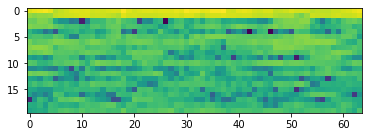

In [35]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MFCC'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MFCC_CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 74
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

Model: "2660_CNN_MFCC_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 64, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 20, 64, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 20, 64, 32)        128       
_________________________________________________________________
activation_18 (Activation)   (None, 20, 64, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 10, 32, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 10, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (Non

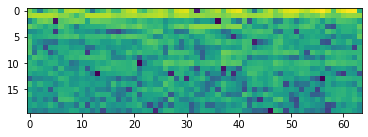

In [42]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MFCC'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("EXTENDED BALLROOM", "mfcc", split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MFCC_CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 54
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### Melspectrogram (64, 640)

![MELSPECTROGRAM](images/MELSPECTROGRAM.png)

In [43]:
def mel_block(x, n_filters, kernel_size, conv_strides, pool_strides, pool_size):
    x = Conv2D(n_filters, kernel_size, strides = conv_strides, padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # reduce overfitting by oversampling? extracts most prominent features
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x) # to reduce overfitting # shouldnt do this when its first level
    return x

In [44]:
def MEL_CNN(input_shape, num_genres, name):
    inpt = Input(shape=input_shape)
    
    x = mel_block(inpt, n_filters = 16, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 32, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 64, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (2, 2), pool_size = (2, 2))
    
    x = mel_block(x, n_filters = 128, kernel_size = (3, 3), 
                   conv_strides = (1, 1), pool_strides = (4, 4), pool_size = (4, 4))
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions, name = name)
    return model

#### GTZAN

Model: "7083_CNN_MELSPECTROGRAM_GTZAN_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_10 (Activation)   (None

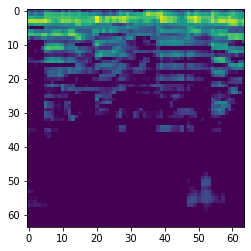

In [38]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MELSPECTROGRAM'
dat = 'GTZAN'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
#print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MEL_CNN(X_train.shape[1:] + (1,), 10, name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 98
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Extended Ballroom

(31936, 64, 64)
Model: "1905_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
activation_22 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activat

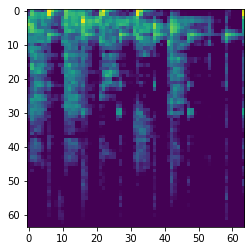

In [45]:
# Get Features
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
split = 10
mod = 'CNN'
feat = 'MELSPECTROGRAM'
dat = 'ExtendedBallroom'
name = '_'.join([x.upper() for x in [str(uid), mod, feat,dat, str(split)]])
X_train, X_test, Y_train, Y_test = getFeatures("Extended Ballroom", feat, split)
print(X_train.shape)
plt.imshow(X_train[1])
# Model
m = MEL_CNN(X_train.shape[1:] + (1,), EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit(X_train, Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 75
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate(X_train, Y_train)
print("Loss:", train[0])
print("Train Accuracy:", train[1])

test = m.evaluate(X_test, Y_test)
print("Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, feat, split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

# Base Results

In the results below, Train Accuracy and Training Accuracy are different. Training Accuracy is the training accuracy from the resulting best epoch, while the Train Accuracy is basically the overall train accuracy of the model. 

In [15]:
MODELS_PATH = os.path.join(os.getcwd(), 'models', 'models.csv')
MODELS = pd.read_csv(MODELS_PATH).set_index("Model Name")
MODELS = MODELS.sort_values('Test Accuracy', ascending = False)
# only base results -- no double inputs and classical
MODELS = MODELS[MODELS['Feature'].isin(['STFT', 'MFCC', 'MELSPECTROGRAM'])]
MODELS = MODELS[MODELS['Method'] == 'CNN']
MODELS

,Method,Dataset,Feature,Split,Test Accuracy,Test Loss,Train Accuracy,Train Loss,Best Epoch,Validation Accuracy,Validation Loss,Training Accuracy,Training Loss
Model Name,,,,,,,,,,,,,
7655_CNN_STFT_EXTENDEDBALLROOM_1,CNN,ExtendedBallroom,STFT,1,0.926158,0.492275,0.958660,0.383785,65.0,0.924883,0.519129,0.940094,0.407142
5229_CNN_STFT_EXTENDEDBALLROOM_2,CNN,ExtendedBallroom,STFT,2,0.921728,0.482177,0.951307,0.384229,38.0,0.917058,0.478434,0.929340,0.423746
5273_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_1,CNN,ExtendedBallroom,MELSPECTROGRAM,1,0.914894,0.658619,0.976198,0.472831,99.0,0.917058,0.693581,0.942443,0.552301
5671_CNN_STFT_EXTENDEDBALLROOM_4,CNN,ExtendedBallroom,STFT,4,0.913901,0.452483,0.967042,0.299174,48.0,0.921722,0.423758,0.941384,0.360010
6520_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_2,CNN,ExtendedBallroom,MELSPECTROGRAM,2,0.911083,0.594169,0.944105,0.448364,51.0,0.918623,0.539827,0.892543,0.593064
7753_CNN_MELSPECTROGRAM_EXTENDEDBALLROOM_4,CNN,ExtendedBallroom,MELSPECTROGRAM,4,0.904822,0.517555,0.929936,0.414237,51.0,0.901761,0.486075,0.860750,0.602696
3375_CNN_STFT_EXTENDEDBALLROOM_5,CNN,ExtendedBallroom,STFT,5,0.903808,0.492371,0.945140,0.365856,39.0,0.910770,0.472410,0.926570,0.398633
7137_CNN_STFT_EXTENDEDBALLROOM_8,CNN,ExtendedBallroom,STFT,8,0.903413,0.473348,0.947432,0.318092,53.0,0.895499,0.492155,0.923329,0.383254
6968_CNN_STFT_EXTENDEDBALLROOM_10,CNN,ExtendedBallroom,STFT,10,0.894664,0.462838,0.934463,0.352995,48.0,0.891046,0.484993,0.903867,0.443369


In [17]:
for d in ['GTZAN', 'ExtendedBallroom']:
    print(d + ':')
    for i in [1, 2, 4, 5, 8, 10]:
        temp = MODELS[MODELS["Split"] == i]
        temp = temp[temp['Dataset'] == d]
        test_a = temp["Test Accuracy"].mean()
        train_a = temp["Train Accuracy"].mean()
        v = temp["Validation Loss"].mean()
        print(f"{i} split: Avg test Accuracy: {test_a:.3f}, Avg train Accuracy: {train_a:.3f}, Avg validation Loss: {v:.3f}")
        
print("Total")
for i in [1, 2, 4, 5, 8, 10]:
    temp = MODELS[MODELS["Split"] == i]
    test_a = temp["Test Accuracy"].mean()
    train_a = temp["Train Accuracy"].mean()
    v = temp["Validation Loss"].mean()
    print(f"{i} split: Avg test Accuracy: {test_a:.3f}, Avg train Accuracy: {train_a:.3f}, Avg validation Loss: {v:.3f}")

GTZAN:
1 split: Avg test Accuracy: 0.490, Avg train Accuracy: 0.604, Avg validation Loss: 2.082
2 split: Avg test Accuracy: 0.528, Avg train Accuracy: 0.671, Avg validation Loss: 2.088
4 split: Avg test Accuracy: 0.790, Avg train Accuracy: 0.872, Avg validation Loss: 0.884
5 split: Avg test Accuracy: 0.760, Avg train Accuracy: 0.862, Avg validation Loss: 0.820
8 split: Avg test Accuracy: 0.801, Avg train Accuracy: 0.879, Avg validation Loss: 0.799
10 split: Avg test Accuracy: 0.806, Avg train Accuracy: 0.897, Avg validation Loss: 0.780
ExtendedBallroom:
1 split: Avg test Accuracy: 0.753, Avg train Accuracy: 0.796, Avg validation Loss: 0.943
2 split: Avg test Accuracy: 0.896, Avg train Accuracy: 0.939, Avg validation Loss: 0.519
4 split: Avg test Accuracy: 0.884, Avg train Accuracy: 0.926, Avg validation Loss: 0.519
5 split: Avg test Accuracy: 0.881, Avg train Accuracy: 0.929, Avg validation Loss: 0.506
8 split: Avg test Accuracy: 0.863, Avg train Accuracy: 0.906, Avg validation Loss: 0

##### With the results above, I decided to use Split of 8s due to having more sample sizes which would lead to less overfitting and still having a high enough test accuracy.

## Confusion Matrix

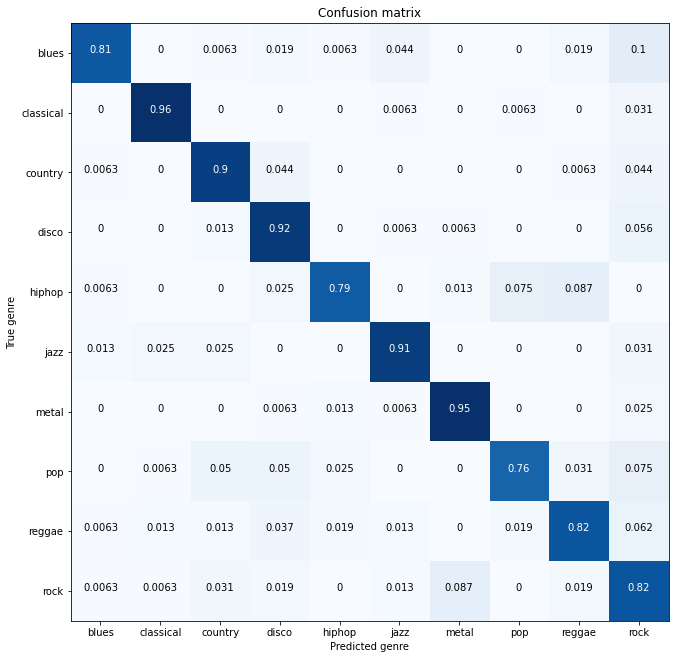

In [24]:
dat = 'GTZAN'
feat = 'STFT'
split = 8
model = get_model('CNN', dat, feat, split)
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
del X_train, Y_train # not needed

preds = model.predict(X_test)
cm = confusion_matrix(y_true = Y_test.argmax(axis = 1), y_pred = preds.argmax(axis = 1))
cnf_matrix(cm, GTZAN['genres'], name = f'{dat}-{feat}-{split}')

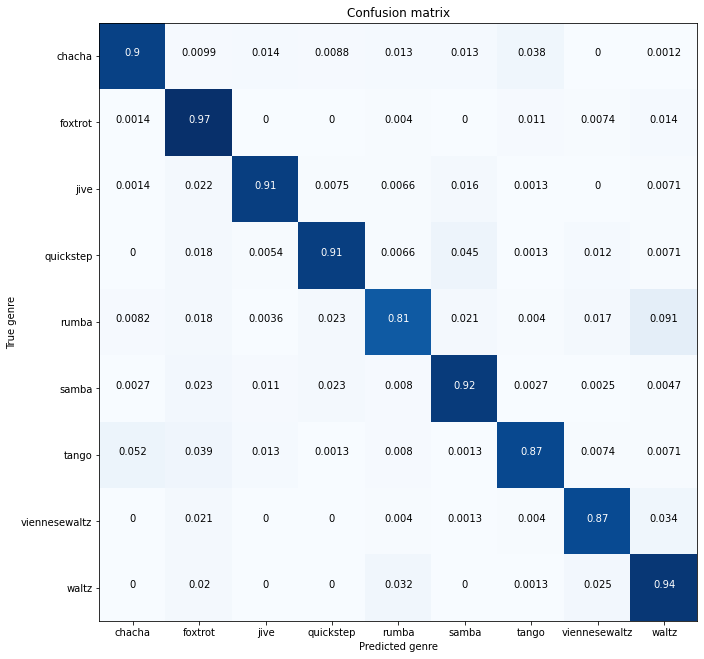

In [25]:
dat = 'ExtendedBallroom'
model = get_model('CNN', dat, feat, split)
dat = 'Extended Ballroom'
X_train, X_test, Y_train, Y_test = getFeatures(dat, feat, split)
del X_train, Y_train # not needed

preds = model.predict(X_test)
cm = confusion_matrix(y_true = Y_test.argmax(axis = 1), y_pred = preds.argmax(axis = 1))
cnf_matrix(cm, EXTENDED_BALLROOM['genres'], name = f'{dat}-{feat}-{split}')

# Dual CNN + Classical

![Dual CNN + Classical](images/DUALCNNCLASSICAL.png)

In [ ]:
def classical_parallel_model(model1, x_train1, x_test1, y_train1, y_test1, 
                             model2, x_train2, x_test2, y_train2, y_test2,
                             num_genres, name, classifier):
    # layer name need to be unique
    i = 0
    for layer in model1.layers:
        layer._name += f"_{i}"
        i += 1
    for layer in model2.layers:
        layer._name += f"_{i}"
        i += 1
    
    m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
    m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
    m1 = Model(inputs = model1.input, outputs = m1_layer)
    m2 = Model(inputs = model2.input, outputs = m2_layer)

    # feature extraction
    m1_output = m1.predict(x_train1)
    m2_output = m2.predict(x_train2)
    output_features = np.column_stack((m1_output, m2_output)) # concatenation
    
    global X_train1, X_train2
    del X_train1, X_train2, x_train1, x_train2 # delete unneeded  var cuz takes up too much space

    # testing
    testing_m1_output = m1.predict(x_test1)
    testing_m2_output = m2.predict(x_test2)
    testing_output_features = np.column_stack((testing_m1_output, testing_m2_output)) # concatenation
    
    global X_test1, X_test2
    del X_test1, X_test2, x_test1, x_test2 # delete unneeded var cuz takes up too much space

    notOHE = [np.argmax(x) for x in y_train2] # inverse one hot encoding - ytrain2 and ytrain1 same
    notOHEtest = [np.argmax(x) for x in y_test1] # ytest1, ytest2 same
    
    global Y_train1, Y_train2, Y_test1, Y_test2
    del Y_train1, Y_train2, Y_test1, Y_test2, y_train1, y_train2, y_test1, y_test2
    
    PIPING = [
        ('scaling', StandardScaler()), 
        # Standardize features by removing the mean and scaling to unit variance
        ('variance_tresh', VarianceThreshold(threshold=(0.1))), 
        # removes low variance features
        ('feature_selection', SelectFromModel(lgbm.LGBMClassifier()))
        # Meta-transformer for selecting features based on importance weights.
        # Light gradient boosting model -- fastest while being accurate
    ]

    if classifier == 'rf':
        params = {
            "algo__n_estimators": [100, 200, 300, 500],
            "algo__criterion": ["gini", "entropy"],
            "algo__max_depth": [10, None]
        }
        PIPING.append(('algo', RandomForestClassifier()))
        pipe = Pipeline(PIPING)
    elif classifier == 'lr':
        params = {
            "algo__penalty": ["l2"],
            "algo__C": [0.1, 0.25, 0.5],
            "algo__max_iter": [500],
            "algo__solver": ["lbfgs"]
        }
        PIPING.append(('algo', LogisticRegression()))
        pipe = Pipeline(PIPING)
    elif classifier == 'svm':
        params = {
            "algo__C": [0.25, 0.5, 2, 4, 6],
            "algo__kernel": ['rbf', 'linear'],
        }
        PIPING.append(('algo', SVC()))
        pipe = Pipeline(PIPING)
    elif classifier == 'knn':
        params = {
            'algo__n_neighbors': [3, 5, 7, 10],
            'algo__metric': ['euclidean']
        }
        PIPING.append(('nca', NeighborhoodComponentsAnalysis()))
        PIPING.append(('algo', KNeighborsClassifier()))
        pipe = Pipeline(PIPING)
    
    grid = GridSearchCV(pipe, params, scoring = 'accuracy', n_jobs = 6, cv = 10, verbose = 3)
    grid.fit(output_features, notOHE)
    val_acc = grid.best_score_
    print("best score on validation set (accuracy) = {:.4f}".format(grid.best_score_))
    
    preds = grid.predict(output_features)
    train_acc = accuracy_score(preds, notOHE)
    print("best score on training set (accuracy) = {:.4f}".format(accuracy_score(preds, notOHE)))

    preds = grid.predict(testing_output_features)
    test_acc = accuracy_score(preds, notOHEtest)
    print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(preds, notOHEtest)))
    
    return (grid, test_acc, train_acc, val_acc)

In [ ]:
def parallel_model(model1, model2, num_genres, name):
    # layer name need to be unique
    i = 0
    for layer in model1.layers:
        layer._name += f"_{i}"
        i += 1
    for layer in model2.layers:
        layer._name += f"_{i}"
        i += 1
    
    # get flattened layer for each
    m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
    m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
    
    # Merged models
    merged = Concatenate()([m1_layer, m2_layer])
    
    x = Flatten()(merged)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.25)(x)
    
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer = tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs = [model1.input, model2.input], outputs=predictions, name = name)
    return model

## STFT + MFCC

![STFT](images/STFT.png)
![MFCC](images/MFCC.png)

### GTZAN

In [ ]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'GTZAN' # for name
DATA = "GTZAN" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MFCC'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [ ]:
m = parallel_model(model1, model2, GTZAN['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 30
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

In [ ]:
classifiers = ['lr', 'rf', 'svm', 'knn']
for classifier in classifiers:
    # Get Features and Models
    split = 8
    mod = 'CNN'
    dat = 'GTZAN' # for name
    DATA = "GTZAN" # to get feature
    uid = np.random.randint(1, 10000) # 'unique' id
    while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
        uid = np.random.randint(1, 10000)

    feat1 = 'STFT'
    model1 = get_model(mod, dat, feat1, split)
    X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

    feat2 = 'MFCC'
    model2 = get_model(mod, dat, feat2, split)
    X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
    
    name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, classifier, dat, str(split)]])
    
    # training
    pm, test_acc, train_acc, val_acc = classical_parallel_model(model1, X_train1, X_test1, Y_train1, Y_test1,
                                                                model2, X_train2, X_test2, Y_train2, Y_test2,
                                                                GTZAN['nGenres'], name, classifier)
    
    joblib.dump(pm, f'models/{name}.pkl') # save model
    # save stats of model
    cur_mod_stats = pd.DataFrame([[name, mod + " + " + classifier.upper(), dat, ', '.join([feat1, feat2]), split, 
                                   test_acc, None, train_acc, None,
                                 None, val_acc, None, None, None]], columns = MODEL_COLS)
    cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### Extended Ballroom

In [ ]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'ExtendedBallroom' # for name, cant have space
DATA = "EXTENDED BALLROOM" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MFCC'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [ ]:
m = parallel_model(model1, model2, EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 19
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

In [ ]:
classifiers = ['lr', 'rf', 'svm', 'knn']
for classifier in classifiers:
    # Get Features and Models
    split = 8
    mod = 'CNN'
    dat = 'ExtendedBallroom' # for name, cant have space
    DATA = "EXTENDED BALLROOM" # to get feature
    uid = np.random.randint(1, 10000) # 'unique' id
    while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
        uid = np.random.randint(1, 10000)

    feat1 = 'STFT'
    model1 = get_model(mod, dat, feat1, split)
    X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

    feat2 = 'MFCC'
    model2 = get_model(mod, dat, feat2, split)
    X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)

    name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, classifier, dat, str(split)]])
    
    # training
    pm, test_acc, train_acc, val_acc = classical_parallel_model(model1, X_train1, X_test1, Y_train1, Y_test1,
                                                                model2, X_train2, X_test2, Y_train2, Y_test2,
                                                                EXTENDED_BALLROOM['nGenres'], name, classifier)
    
    joblib.dump(pm, f'models/{name}.pkl') # save model
    # save stats of model
    cur_mod_stats = pd.DataFrame([[name, mod + " + " + classifier.upper(), dat, ', '.join([feat1, feat2]), split, 
                                   test_acc, None, train_acc, None,
                                 None, val_acc, None, None, None]], columns = MODEL_COLS)
    cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

## STFT + MELSPECTROGRAM

![STFT](images/STFT.png)
![MELSPECTROGRAM](images/MELSPECTROGRAM.png)

### GTZAN

In [ ]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'GTZAN' # for name
DATA = "GTZAN" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [ ]:
m = parallel_model(model1, model2, GTZAN['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 18
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

In [ ]:
classifiers = ['lr', 'rf', 'svm', 'knn']
for classifier in classifiers:
    # Get Features and Models
    split = 8
    mod = 'CNN'
    dat = 'GTZAN' # for name
    DATA = "GTZAN" # to get feature
    uid = np.random.randint(1, 10000) # 'unique' id
    while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
        uid = np.random.randint(1, 10000)

    feat1 = 'STFT'
    model1 = get_model(mod, dat, feat1, split)
    X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

    feat2 = 'MELSPECTROGRAM'
    model2 = get_model(mod, dat, feat2, split)
    X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
    
    name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, classifier, dat, str(split)]])
    
    # training
    pm, test_acc, train_acc, val_acc = classical_parallel_model(model1, X_train1, X_test1, Y_train1, Y_test1,
                                                                model2, X_train2, X_test2, Y_train2, Y_test2,
                                                                GTZAN['nGenres'], name, classifier)
    
    joblib.dump(pm, f'models/{name}.pkl') # save model
    # save stats of model
    cur_mod_stats = pd.DataFrame([[name, mod + " + " + classifier.upper(), dat, ', '.join([feat1, feat2]), split, 
                                   test_acc, None, train_acc, None,
                                 None, val_acc, None, None, None]], columns = MODEL_COLS)
    cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### Extended Ballroom

In [ ]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'ExtendedBallroom' # for name, cant have space
DATA = "EXTENDED BALLROOM" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [ ]:
m = parallel_model(model1, model2, EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 15
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

In [ ]:
classifiers = ['lr', 'rf', 'svm', 'knn']
classifiers = ['knn'] # takes too long -- takes up too much memory
for classifier in classifiers:
    # Get Features and Models
    split = 8
    mod = 'CNN'
    dat = 'ExtendedBallroom' # for name, cant have space
    DATA = "EXTENDED BALLROOM" # to get feature
    uid = np.random.randint(1, 10000) # 'unique' id
    while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
        uid = np.random.randint(1, 10000)

    feat1 = 'STFT'
    model1 = get_model(mod, dat, feat1, split)
    X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

    feat2 = 'MELSPECTROGRAM'
    model2 = get_model(mod, dat, feat2, split)
    X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)

    name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, classifier, dat, str(split)]])
    
    # training
    pm, test_acc, train_acc, val_acc = classical_parallel_model(model1, X_train1, X_test1, Y_train1, Y_test1,
                                                                model2, X_train2, X_test2, Y_train2, Y_test2,
                                                                EXTENDED_BALLROOM['nGenres'], name, classifier)
    
    joblib.dump(pm, f'models/{name}.pkl') # save model
    # save stats of model
    cur_mod_stats = pd.DataFrame([[name, mod + " + " + classifier.upper(), dat, ', '.join([feat1, feat2]), split, 
                                   test_acc, None, train_acc, None,
                                 None, val_acc, None, None, None]], columns = MODEL_COLS)
    cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

## MFCC + MELSPECTROGRAM

![MFCC](images/MFCC.png)
![MELSPECTROGRAM](images/MELSPECTROGRAM.png)

### GTZAN

In [ ]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'GTZAN' # for name
DATA = "GTZAN" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'MFCC'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [ ]:
m = parallel_model(model1, model2, GTZAN['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 40
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

In [ ]:
classifiers = ['lr', 'rf', 'svm', 'knn']
for classifier in classifiers:
    # Get Features and Models
    split = 8
    mod = 'CNN'
    dat = 'GTZAN' # for name
    DATA = "GTZAN" # to get feature
    uid = np.random.randint(1, 10000) # 'unique' id
    while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
        uid = np.random.randint(1, 10000)

    feat1 = 'MFCC'
    model1 = get_model(mod, dat, feat1, split)
    X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

    feat2 = 'MELSPECTROGRAM'
    model2 = get_model(mod, dat, feat2, split)
    X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
    
    name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, classifier, dat, str(split)]])
    
    # training
    pm, test_acc, train_acc, val_acc = classical_parallel_model(model1, X_train1, X_test1, Y_train1, Y_test1,
                                                                model2, X_train2, X_test2, Y_train2, Y_test2,
                                                                GTZAN['nGenres'], name, classifier)
    
    joblib.dump(pm, f'models/{name}.pkl') # save model
    # save stats of model
    cur_mod_stats = pd.DataFrame([[name, mod + " + " + classifier.upper(), dat, ', '.join([feat1, feat2]), split, 
                                   test_acc, None, train_acc, None,
                                 None, val_acc, None, None, None]], columns = MODEL_COLS)
    cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

### Extended Ballroom

In [ ]:
# Get Features and Models
split = 8
mod = 'CNN'
dat = 'ExtendedBallroom' # for name, cant have space
DATA = "EXTENDED BALLROOM" # to get feature
uid = np.random.randint(1, 10000) # 'unique' id
while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
    uid = np.random.randint(1, 10000)
    
feat1 = 'MFCC'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
# Ytest_1, Y_test2 are equal, same with train

name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, dat, str(split)]])

#### Base

In [ ]:
m = parallel_model(model1, model2, EXTENDED_BALLROOM['nGenres'], name)
opt = keras.optimizers.Adam(lr = 0.001)
m.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])
m.summary()

In [ ]:
checkpoint_path = 'checkpoints/{val_loss:.2f}-{epoch:02d}.hdf5'
history = m.fit([X_train1, X_train2], Y_train1, epochs = 100, batch_size = BATCH_SIZE, validation_split = 0.2,
     callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 15),
                 ModelCheckpoint(filepath = checkpoint_path, save_weights_only = False,
                                monitor = 'val_loss', mode = 'min',
                                save_best_only = True)])

In [ ]:
plot_graph(history, name)

In [ ]:
best_epoch = 12
train_acc, train_loss, val_acc, val_loss = get_res(history, best_epoch)
#print(train_acc, val_acc, train_loss, val_loss)

m.load_weights(f'checkpoints/{val_loss:.2f}-{best_epoch:02d}.hdf5') # gets the best model weights

In [ ]:
train = m.evaluate([X_train1, X_train2], Y_train1)
print("Train Loss:", train[0])
print("Train Accuracy:", train[1])
test = m.evaluate([X_test1, X_test2], Y_test1)
print("Test Loss:", test[0])
print("Test Accuracy:", test[1])

In [ ]:
m.save(f'models/{name}.h5') # save model
# save stats of model
cur_mod_stats = pd.DataFrame([[name, mod, dat, ', '.join([feat1, feat2]), split, test[1], test[0], train[1], train[0],
                             best_epoch, val_acc, val_loss, train_acc, train_loss]], columns = MODEL_COLS)
cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

#### Classical

In [ ]:
classifiers = ['lr', 'rf', 'svm', 'knn']
for classifier in classifiers:
    # Get Features and Models
    split = 8
    mod = 'CNN'
    dat = 'ExtendedBallroom' # for name, cant have space
    DATA = "EXTENDED BALLROOM" # to get feature
    uid = np.random.randint(1, 10000) # 'unique' id
    while sum([x.startswith(str(uid)) for x in os.listdir('models/')]) != 0: # if duplicate
        uid = np.random.randint(1, 10000)

    feat1 = 'MFCC'
    model1 = get_model(mod, dat, feat1, split)
    X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)

    feat2 = 'MELSPECTROGRAM'
    model2 = get_model(mod, dat, feat2, split)
    X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)

    name = '_'.join([x.upper() for x in [str(uid), mod, feat1, feat2, classifier, dat, str(split)]])
    
    # training
    pm, test_acc, train_acc, val_acc = classical_parallel_model(model1, X_train1, X_test1, Y_train1, Y_test1,
                                                                model2, X_train2, X_test2, Y_train2, Y_test2,
                                                                EXTENDED_BALLROOM['nGenres'], name, classifier)
    
    joblib.dump(pm, f'models/{name}.pkl') # save model
    # save stats of model
    cur_mod_stats = pd.DataFrame([[name, mod + " + " + classifier.upper(), dat, ', '.join([feat1, feat2]), split, 
                                   test_acc, None, train_acc, None,
                                 None, val_acc, None, None, None]], columns = MODEL_COLS)
    cur_mod_stats.to_csv('models/models.csv', mode = 'a', header = False, index = False)

# Final Results

In [12]:
name = '5201_CNN_STFT_MFCC_KNN_EXTENDEDBALLROOM_8'
model = joblib.load(f'models/{name}.pkl')
model_df = pd.DataFrame(model.cv_results_)
model_df.sort_values(by = ['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__metric,param_algo__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,660.721866,429.673880,0.000000,0.000000,euclidean,3,"{'algo__metric': 'euclidean', 'algo__n_neighbo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,944.128096,2646.022085,2.027270,6.081811,euclidean,5,"{'algo__metric': 'euclidean', 'algo__n_neighbo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.911903,NaN,NaN,2
2,1223.710365,2817.421700,2.306234,6.918703,euclidean,7,"{'algo__metric': 'euclidean', 'algo__n_neighbo...",NaN,NaN,0.966341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,308.498199,87.100520,0.000000,0.000000,euclidean,10,"{'algo__metric': 'euclidean', 'algo__n_neighbo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


Keep in mind, for some models, KNN has NaN values for split test scores and validation accuracy for reasons I am not sure of. Probably due to memory issues? Ex. 5201_CNN_STFT_MFCC_KNN_EXTENDEDBALLROOM_8, 8311_CNN_STFT_MELSPECTROGRAM_KNN_EXTENDEDBALLROOM_8, 1288_CNN_MFCC_MELSPECTROGRAM_KNN_EXTENDEDBALLROOM_8

So the KNN models, at least for the models specified above, do not have the best possible accuracy.

In [13]:
MODELS_PATH = os.path.join(os.getcwd(), 'models', 'models.csv')
MODELS = pd.read_csv(MODELS_PATH).set_index("Model Name")
MODELS = MODELS.sort_values('Test Accuracy', ascending = False)
MODELS = MODELS[MODELS['Split'].isin([5, 8, 10])]
MODELS

,Method,Dataset,Feature,Split,Test Accuracy,Test Loss,Train Accuracy,Train Loss,Best Epoch,Validation Accuracy,Validation Loss,Training Accuracy,Training Loss
Model Name,,,,,,,,,,,,,
7628_CNN_STFT_MELSPECTROGRAM_KNN_GTZAN_8,CNN + KNN,GTZAN,"STFT, MELSPECTROGRAM",8,0.958125,NaN,0.990000,NaN,NaN,0.975313,NaN,NaN,NaN
6428_CNN_STFT_MFCC_KNN_GTZAN_8,CNN + KNN,GTZAN,"STFT, MFCC",8,0.953125,NaN,0.990938,NaN,NaN,0.972344,NaN,NaN,NaN
379_CNN_STFT_MELSPECTROGRAM_SVM_GTZAN_8,CNN + SVM,GTZAN,"STFT, MELSPECTROGRAM",8,0.950625,NaN,0.999375,NaN,NaN,0.981250,NaN,NaN,NaN
4367_CNN_STFT_MFCC_SVM_GTZAN_8,CNN + SVM,GTZAN,"STFT, MFCC",8,0.940000,NaN,0.999375,NaN,NaN,0.977656,NaN,NaN,NaN
6475_CNN_STFT_MELSPECTROGRAM_LR_GTZAN_8,CNN + LR,GTZAN,"STFT, MELSPECTROGRAM",8,0.932500,NaN,0.999375,NaN,NaN,0.971562,NaN,NaN,NaN
757_CNN_STFT_MFCC_SVM_EXTENDEDBALLROOM_8,CNN + SVM,ExtendedBallroom,"STFT, MFCC",8,0.924076,NaN,0.980194,NaN,NaN,0.960737,NaN,NaN,NaN
4630_CNN_STFT_MFCC_LR_GTZAN_8,CNN + LR,GTZAN,"STFT, MFCC",8,0.921250,NaN,0.999062,NaN,NaN,0.968750,NaN,NaN,NaN
1584_CNN_STFT_MFCC_RF_EXTENDEDBALLROOM_8,CNN + RF,ExtendedBallroom,"STFT, MFCC",8,0.919693,NaN,0.999843,NaN,NaN,0.954083,NaN,NaN,NaN
5399_CNN_STFT_MELSPECTROGRAM_SVM_EXTENDEDBALLROOM_8,CNN + SVM,ExtendedBallroom,"STFT, MELSPECTROGRAM",8,0.919537,NaN,0.988414,NaN,NaN,0.960815,NaN,NaN,NaN


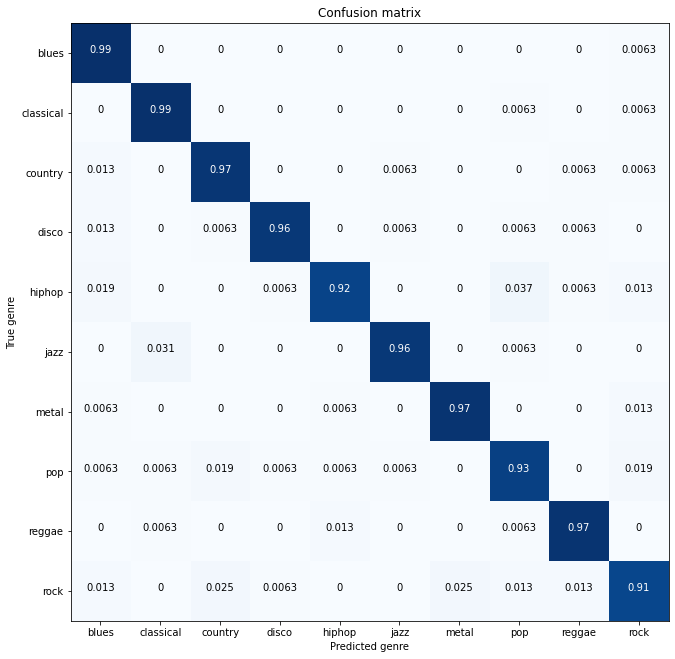

In [26]:
# STFT MELSPECTOGRAM
split = 8
mod = 'CNN'
dat = 'GTZAN' # for name
DATA = "GTZAN" # to get feature
    
feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)
del X_train1, Y_train1

feat2 = 'MELSPECTROGRAM'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
del X_train2, Y_train2

m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
m1 = Model(inputs = model1.input, outputs = m1_layer)
m2 = Model(inputs = model2.input, outputs = m2_layer)

# feature extraction
m1_output = m1.predict(X_test1)
m2_output = m2.predict(X_test2)
X_test = np.column_stack((m1_output, m2_output)) # concatenation

model_name = '7628_CNN_STFT_MELSPECTROGRAM_KNN_GTZAN_8'
model = joblib.load(f'models/{model_name}.pkl')

preds = model.predict(X_test)
cm = confusion_matrix(y_true = Y_test1.argmax(axis = 1), y_pred = preds)
cnf_matrix(cm, GTZAN['genres'], name = model_name)

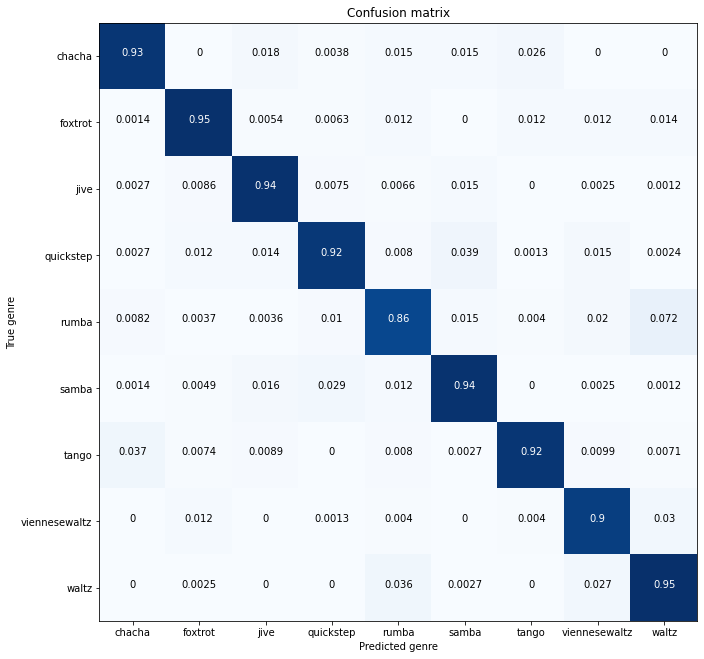

In [27]:
# STFT MFCC
split = 8
mod = 'CNN'
dat = 'ExtendedBallroom' # for name, cant have space
DATA = "EXTENDED BALLROOM" # to get feature

feat1 = 'STFT'
model1 = get_model(mod, dat, feat1, split)
X_train1, X_test1, Y_train1, Y_test1 = getFeatures(DATA, feat1, split)
del X_train1, Y_train1

feat2 = 'MFCC'
model2 = get_model(mod, dat, feat2, split)
X_train2, X_test2, Y_train2, Y_test2 = getFeatures(DATA, feat2, split)
del X_train2, Y_train2

m1_layer = [l.output for l in model1.layers if type(l) == Flatten][0]
m2_layer = [l.output for l in model2.layers if type(l) == Flatten][0]
m1 = Model(inputs = model1.input, outputs = m1_layer)
m2 = Model(inputs = model2.input, outputs = m2_layer)

# feature extraction
m1_output = m1.predict(X_test1)
m2_output = m2.predict(X_test2)
X_test = np.column_stack((m1_output, m2_output)) # concatenation

model_name = '757_CNN_STFT_MFCC_SVM_EXTENDEDBALLROOM_8'
model = joblib.load(f'models/{model_name}.pkl')

preds = model.predict(X_test)
cm = confusion_matrix(y_true = Y_test1.argmax(axis = 1), y_pred = preds)
cnf_matrix(cm, EXTENDED_BALLROOM['genres'], name = model_name)